In [4]:
# Library imports / set up
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# display is required to allow multiple prints in each cell
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
pd.set_option('display.max_colwidth', -1)

In [5]:
# Data is read
dc = pd.read_csv('david_cameron_tweets.csv', sep="|")
tm = pd.read_csv('theresa_may_tweets.csv', sep="|")

# Print out first line to make sure data is read ok
display(dc.head(1))
display(tm.head(1))

# Print rows x columns so we're sure it's ok
display("DC " + str(dc.shape) + ", TM " + str(tm.shape) )

,id,created_at,text
0,1019946110142513152,2018-07-19 14:04:36,Brilliant to see this further investment in Alzheimer’s research. Thank you @BillGates! https://t.co/SRd31NykFx


,id,created_at,text
0,1020286313562628098,2018-07-20 12:36:27,Torbay's @thlof do excellent charitable work raising money to help support @TorbaySDevonNHS. Their dedicated volunteers make a huge difference to the local community and patients - and @kevin_j_foster is a passionate supporter of their work. https://t.co/aqvRqNA5QX


'DC (2680, 3), TM (955, 3)'

In [6]:
# created_at is likely to be parsed as text
# We convert dates to a date/time format so we can do 'maths' on them
dc['created_at'] = pd.to_datetime(dc['created_at'], format='%Y-%m-%d %H:%M:%S')
tm['created_at'] = pd.to_datetime(tm['created_at'], format='%Y-%m-%d %H:%M:%S')

# If ok, dtype should be datetime64[ns] or <M8[ns]
dc.created_at.dtype
tm.created_at.dtype

dtype('<M8[ns]')

dtype('<M8[ns]')

In [7]:
# Min and Max
print("Min " + str(dc['created_at'].min()) + " Max " + str(dc['created_at'].max()))
print("Min " + str(tm['created_at'].min()) + " Max " + str(tm['created_at'].max()))

Min 2012-10-06 16:51:46 Max 2018-07-19 14:04:36
Min 2016-06-30 08:05:36 Max 2018-07-20 12:36:27


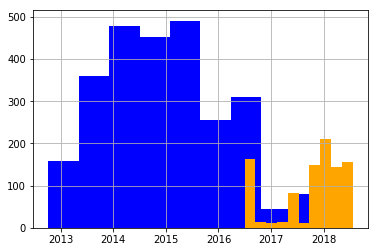

In [30]:
# Distribution of tweets per year
dc['created_at'].hist(color="blue") # blue, David Cameron
tm['created_at'].hist(color="orange") # orange, Theresa May

# 1. Statistics

## 1.1 Time of tweeting: full dataset

Histograms of twitter creation for Cameron (blue) and May (Orange), normalised
Conclusion: Cameron is on average a breakfast/after-lunch type of tweeter, while May has a more pyramidal approach culminating after lunch

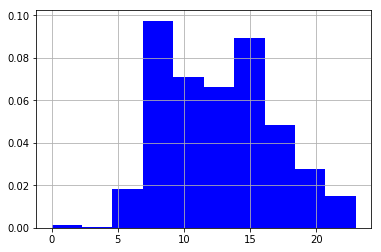

In [31]:
dc['created_at'].dt.hour.hist(density=True, color="blue")

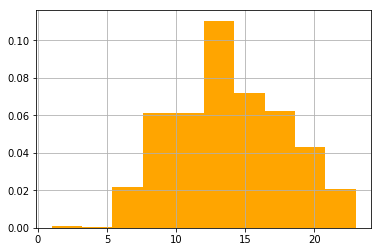

In [29]:
tm['created_at'].dt.hour.hist(density=True, color='Orange')

## 1.2 Tweeting statistics during electoral periods

Does the period immediately preceding an election or referendum affect the pattern of tweeting? 

For David Cameron, these are the periods present before his resignation:
* Scottish Independence Referendum: 21 March 2013 (Scottish Government Announcement) to 18 September 2014 (Referendum Day)
* General Election 2015: 30 March 2015 (Dissolution) to 7 May 2015 (Election Day)
* EU Exit Referendum: 17 December 2015 (Royal Assent) to 23 June 2016 (Referendum Day) 

For Theresa May, there is only one comparable period:
* General Election 2017: 19 April 2017 (Commons vote) to 8 June 2017 (Election Day)

Each period is compared with its complement in the full dataset.

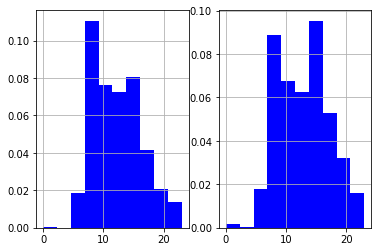

In [48]:
# David Cameron Scottish Referendum
# Conclusion: tweeting pattern was more focussed in the morning during the referendum campaign
dc_SCOT = dc[(dc['created_at'] >= '2013-03-21') & (dc['created_at'] <= '2014-09-18')]
dc_NOTSCOT = dc[(dc['created_at'] < '2013-03-21') | (dc['created_at'] > '2014-09-18')]

fig, axs = plt.subplots(1,2)

dc_SCOT['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[0])
dc_NOTSCOT['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[1])

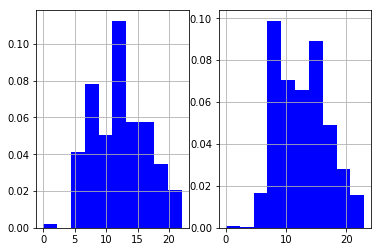

In [45]:
# David Cameron General Election 2015
# Conclusion: More tweets mid-morning
dc_GE15 = dc[(dc['created_at'] >= '2015-03-30') & (dc['created_at'] <= '2015-05-07')]
dc_NOTGE15 = dc[(dc['created_at'] < '2015-03-30') | (dc['created_at'] > '2015-05-07')]

fig, axs = plt.subplots(1,2)

dc_GE15['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[0])
dc_NOTGE15['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[1])

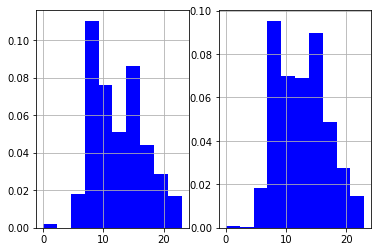

In [47]:
# David Cameron EU Exit Referendum 17 December 2015 to 23 June 2016 (Referendum Day)
# Conclusion: Not much change, but fewer tweets mid-morning
dc_EU = dc[(dc['created_at'] >= '2015-12-17') & (dc['created_at'] <= '2016-06-23')]
dc_NOTEU = dc[(dc['created_at'] < '2015-12-17') | (dc['created_at'] > '2016-06-23')]

fig, axs = plt.subplots(1,2)

dc_EU['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[0])
dc_NOTEU['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[1])

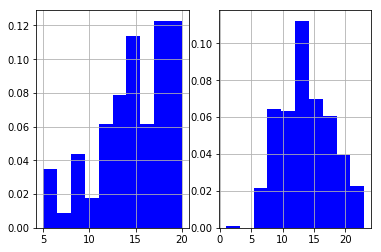

In [50]:
# Theresa May General Election 2017 
# Conclusion: a pattern that skewes a lot towards the evening
tm_GE17 = tm[(tm['created_at'] >= '2017-04-19') & (tm['created_at'] <= '2017-06-08')]
tm_NOTGE17 = tm[(tm['created_at'] < '2017-04-19') | (tm['created_at'] > '2017-06-08')]

fig, axs = plt.subplots(1,2)

tm_GE17['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[0])
tm_NOTGE17['created_at'].dt.hour.hist(density=True, color="blue", ax=axs[1])

# 2. Friendliness and Energy

We will first of all add indices of energy and friendliness to the original dataset, then use these to aggregate in some way to return a temporal analysis.

In [94]:
# Here we define energy and friendliness words
words_energy = ['believe', 'belief', 'action', 'do', 
                'take', 'fast', 'quick', 'as soon as possible', 'law', 'legislate', 
                'respond', 'right', 'wrong']

words_friendliness = ['sympathy', 'concern', 'condolences', 'support', 'understand', 
                      'help', 'assist', 'disaster', 'tragedy', 'visit', 'hustand', 'children' ,
                     'wife', 'remember' 'congratulations', 'my']

In [95]:
# This function returns a pair (energy index, friendliness index) for the text passed as input
#
# It calculates a percentage, e.g.: 
#    energy index = number of occurrences of energy words * 100 / total words in text in input
#
# Example
# energyFriendlinessIndex('My sympathy and concern go to the friends in Greece. I believe.')
#  returns: [8.333333333333334, 16.666666666666668]

import re
import string

def energyFriendlinessIndex(text): 
    # process text to make it searchable (add spaces, replace punctuation)
    text = " " + text.lower() + " "
    translator = str.maketrans('','',string.punctuation)
    text = text.translate(translator)
    
    # total for percentage calculation
    total = sum([1 for i in text.split()])
            
    # search words in string
    energyCount = 0
    for search_word in words_energy:
        my_regex = r" " + re.escape(search_word) + r" "
        occurrences = len(re.findall(my_regex, text))
        energyCount = energyCount + occurrences
        
    friendlinessCount = 0
    for search_word in words_friendliness:
        my_regex = r" " + re.escape(search_word) + r" "
        occurrences = len(re.findall(my_regex, text))
        friendlinessCount = friendlinessCount + occurrences
        
    return [ energyCount*100/total, friendlinessCount*100/total ]

In [96]:
# Indices of energy and friendliness for the whole dataset
# We apply the function to the original data frame
dc['energy'] = dc.apply (lambda row: energyFriendlinessIndex (row['text'])[0],axis=1)
dc['friendliness'] = dc.apply (lambda row: energyFriendlinessIndex (row['text'])[1],axis=1)
                   
tm['energy'] = tm.apply (lambda row: energyFriendlinessIndex (row['text'])[0],axis=1)
tm['friendliness'] = tm.apply (lambda row: energyFriendlinessIndex (row['text'])[1],axis=1)
                   
dc.head(1)
tm.head(1)

,id,created_at,text,YearWeek,energy,friendliness
0,1019946110142513152,2018-07-19 14:04:36,Brilliant to see this further investment in Alzheimer’s research. Thank you @BillGates! https://t.co/SRd31NykFx,2018/29,0.0,0.0


,id,created_at,text,YearWeek,energy,friendliness
0,1020286313562628098,2018-07-20 12:36:27,Torbay's @thlof do excellent charitable work raising money to help support @TorbaySDevonNHS. Their dedicated volunteers make a huge difference to the local community and patients - and @kevin_j_foster is a passionate supporter of their work. https://t.co/aqvRqNA5QX,2018/29,2.857143,5.714286


## 2.1 Basic descriptive statistics

In [99]:
dc['energy'].mean()
dc['energy'].var()
dc['friendliness'].mean()
dc['friendliness'].var()

0.3987834478108052

2.2977052771503077

1.340945431663262

7.811279025075449

In [100]:
tm['energy'].mean()
tm['energy'].var()
tm['friendliness'].mean()
tm['friendliness'].var()

0.521673776853664

2.3101459318226154

1.0881648914219169

5.382011361183821

## 2.2 Week aggregate

Let's see how friendliness and energy vary along time.

In [118]:
# Add week of the year
dc['YearWeek'] = dc['created_at'].apply(lambda x: "%d/%s" % (x.year, str(x.week).zfill(2)))
tm['YearWeek'] = tm['created_at'].apply(lambda x: "%d/%s" % (x.year, str(x.week).zfill(2)))

In [127]:
# Aggregate by week and calculate the mean of energy and friendliness
dcw = dc.groupby(['YearWeek'], as_index=False).mean() 
tmw = tm.groupby(['YearWeek'], as_index=False).mean() 
dcw.head(5)
tmw.head(5)
# to check dc[dc['YearWeek']=='2012/40']

,YearWeek,id,energy,friendliness
0,2012/40,254774625780776960,2.777778,2.272727
1,2012/41,255589727446646784,1.784245,1.216063
2,2012/42,258833145270519808,1.250000,0.000000
3,2012/43,261154368493420544,1.449275,1.518288
4,2012/44,263696834225117184,0.000000,0.000000


,YearWeek,id,energy,friendliness
0,2016/26,749431989904844032,0.555269,1.262015
1,2016/27,750930744618471552,0.376894,1.286178
2,2016/28,752619106258736128,0.271739,0.000000
3,2016/29,756061619734482944,0.000000,0.000000
4,2016/30,759649054779408384,0.000000,0.000000


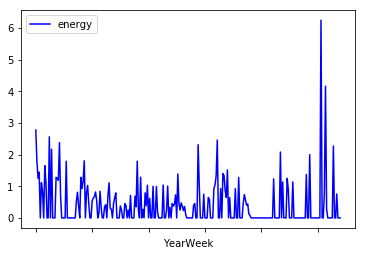

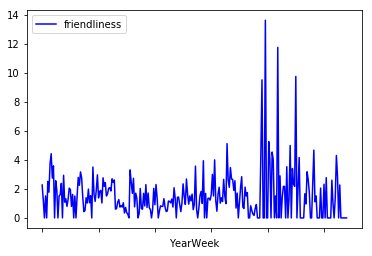

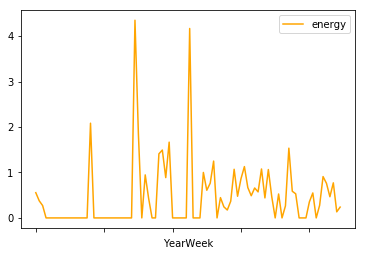

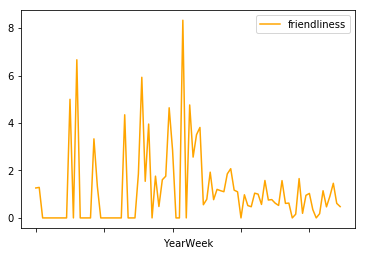

In [154]:
# Conclusions: Plotting over time, it is apparent that David Cameron has a marked increase
# in both energy and friendliness

# David Cameron
dcw.plot(x='YearWeek', y='energy',  color='blue')
dcw.plot(x='YearWeek', y='friendliness',  color='blue')

# Teresa May
tmw.plot(x='YearWeek', y='energy',  color='orange')
tmw.plot(x='YearWeek', y='friendliness',  color='orange')

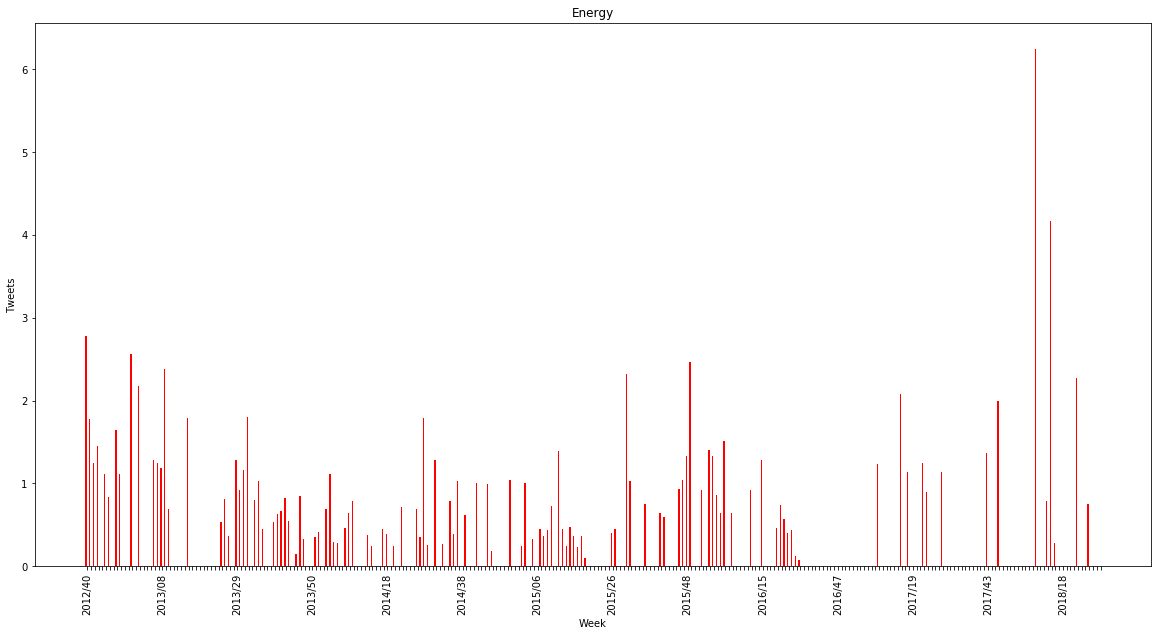

In [156]:
# Example for a better chart 
setDC = dcw['energy']

fig, ax = plt.subplots(figsize=(20, 10))  
index = np.arange(len(dcw)) # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(index, setDC, width, color='r')
# p2 = ax.bar(index + width, setTM, width, color='y')

ax.set_title('Energy')

# set axis ticks, and make visible only 1 every 20
ax.set_xticks(index + width )
ax.set_xticklabels(dcw['YearWeek'])
plt.xticks(fontsize=10, rotation='vertical')
for label in ax.get_xticklabels():
    label.set_visible(False)
for label in ax.get_xticklabels()[::20]:
    label.set_visible(True)

# Print legend and labels
# ax.legend((p1[0]), ('DC'))
ax.set_ylabel('Tweets')
ax.set_xlabel('Week')

ax.autoscale_view()

plt.show(); # ; suppresses printouts



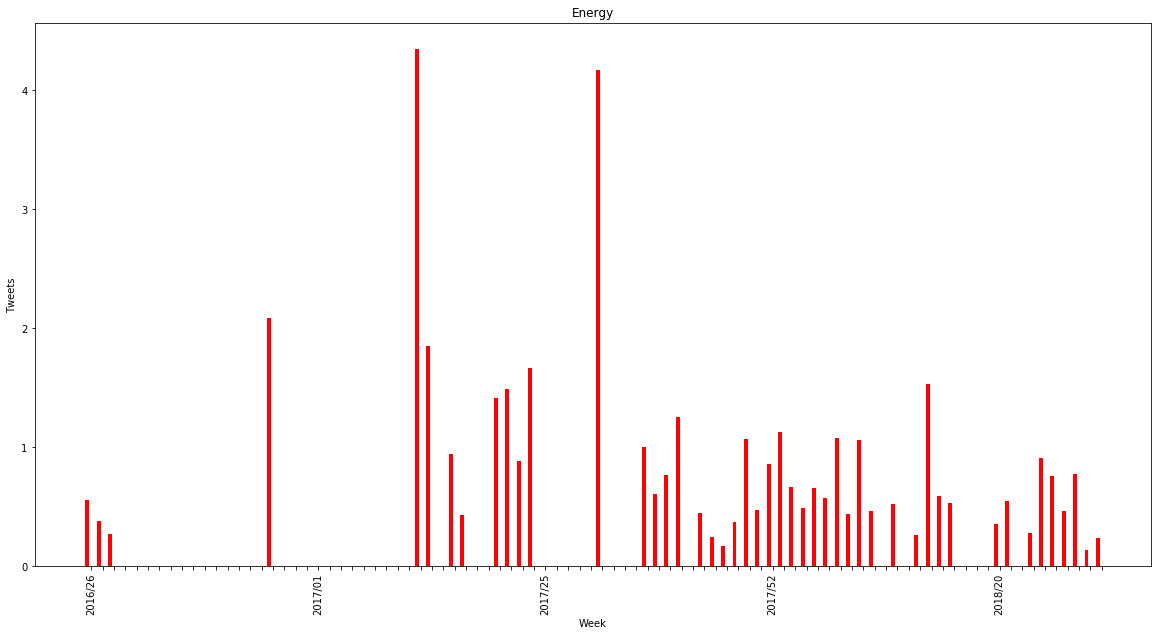

In [157]:
# A better chart (example)
setTM = tmw['energy']

fig, ax = plt.subplots(figsize=(20, 10))  
index = np.arange(len(tmw)) # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(index, setTM, width, color='r')
# p2 = ax.bar(index + width, setTM, width, color='y')

ax.set_title('Energy')

# set axis ticks, and make visible only 1 every 20
ax.set_xticks(index + width )
ax.set_xticklabels(tmw['YearWeek'])
plt.xticks(fontsize=10, rotation='vertical')
for label in ax.get_xticklabels():
    label.set_visible(False)
for label in ax.get_xticklabels()[::20]:
    label.set_visible(True)

# Print legend and labels
# ax.legend((p1[0]), ('DC'))
ax.set_ylabel('Tweets')
ax.set_xlabel('Week')

ax.autoscale_view()

plt.show();



## 2.3 Electoral periods energy/friendliness statistics

In [162]:
# Re-extract slices

dc_SCOT = dc[(dc['created_at'] >= '2013-03-21') & (dc['created_at'] <= '2014-09-18')]
dc_NOTSCOT = dc[(dc['created_at'] < '2013-03-21') | (dc['created_at'] > '2014-09-18')]
dc_GE15 = dc[(dc['created_at'] >= '2015-03-30') & (dc['created_at'] <= '2015-05-07')]
dc_NOTGE15 = dc[(dc['created_at'] < '2015-03-30') | (dc['created_at'] > '2015-05-07')]
dc_EU = dc[(dc['created_at'] >= '2015-12-17') & (dc['created_at'] <= '2016-06-23')]
dc_NOTEU = dc[(dc['created_at'] < '2015-12-17') | (dc['created_at'] > '2016-06-23')]
tm_GE17 = tm[(tm['created_at'] >= '2017-04-19') & (tm['created_at'] <= '2017-06-08')]
tm_NOTGE17 = tm[(tm['created_at'] < '2017-04-19') | (tm['created_at'] > '2017-06-08')]


print("DC Energy")

dc['energy'].mean()
dc_SCOT['energy'].mean()
dc_GE15['energy'].mean()
dc_EU['energy'].mean()

print ("DC Friendliness")

dc['friendliness'].mean()
dc_SCOT['friendliness'].mean()
dc_GE15['friendliness'].mean()
dc_EU['friendliness'].mean()

print ("TM Energy")

tm['energy'].mean()
tm_GE17['energy'].mean()

print ("TM Friendliness")

tm['friendliness'].mean()
tm_GE17['friendliness'].mean()


# Conclusions: DC had much higher energy during the EU Referendum campaign, 
# while max friendliness during GE 2015. May had marked higher energy and 
# friendliness in her only electoral eriod.

DC Energy


0.3987834478108052

0.3818591459127015

0.31042478715233246

0.4111175357692607

DC Friendliness


1.340945431663262

1.384781681027868

1.6185673496926807

1.1091216206675072

TM Energy


0.521673776853664

0.7691984855240557

TM Friendliness


1.0881648914219169

1.8374536434335864

# 3. Words association strength (log odds analysis)
Here we investigate words associations. For example:
* which words associate more strongly with David Cameron vs Theresa May
* which David Cameron's words associate more strongly with his electoral periods vs ordinary
* etc

In [164]:
# Create sets of unique words
from collections import Counter

dc['lowercase'] = dc['text'].map(lambda x: x.lower())
tm['lowercase'] = tm['text'].map(lambda x: x.lower())

# Cameron
dc_counter = Counter(" ".join(dc['lowercase']).split(" "))
dc_counter_frame = pd.DataFrame.from_dict(dc_counter, orient='index')
dc_counter_frame.columns = ['count']
dc_counter_frame = dc_counter_frame.sort_values(by=['count'], ascending=False)

# May
tm_counter = Counter(" ".join(tm['lowercase']).split(" "))
tm_counter_frame = pd.DataFrame.from_dict(tm_counter, orient='index')#
tm_counter_frame.columns = ['count']
tm_counter_frame = tm_counter_frame.sort_values(by=['count'], ascending=False)


In [166]:
# This function returns the log odds ratio for two dataframe, providing the two counter 
# NB: We use Laplace smoothing: add 1 instead of returning Nan
import numpy as np
import math
def word_log_odds_ratio(word, df1, df2, df1counter, df2counter):
    

    df1len = len(" ".join(df1['text']).split(" "))
    df2len = len(" ".join(df2['text']).split(" "))
  
    countdf1 = df1counter[df1counter.index == word]['count']
    countdf2 = df2counter[df2counter.index == word]['count']

    # Laplace smoothing
    if len(countdf1) == 0:
        countdf1 = 1
    else:
        countdf1 = countdf1[0]
    if len(countdf2) ==0:
        countdf2 = 1
    else:
        countdf2 = countdf2[0]
   
    p1 = countdf1 * 100 / df1len
    p2 = countdf2 * 100 / df2len
    logsodd = np.log(p1/p2)

    return logsodd
    
# Example word_log_odds_ratio('me', dc, tm , dc_counter_frame, tm_counter_frame)

In [171]:
# To generate a log odds dataframe we need two things
# 1. generate a unique set of words (merging the two data frames of DC and TM)
# 2. get the log odds for each word
# In reality, here it's quicker to just create the df, then drop duplicates

logodds = pd.DataFrame(columns=['count'])

# Round 1: David Cameron
for index, row in dc_counter_frame[dc_counter_frame['count']>5].iterrows():
    word = index       
    logs = word_log_odds_ratio(word, dc, tm, dc_counter_frame, tm_counter_frame)
    logodds.loc[word] = pd.Series({'count':logs})
        
# Round 2: Theresa May
for index, row in tm_counter_frame[tm_counter_frame['count']>5].iterrows():
    word = index       
    logs = word_log_odds_ratio(word, dc, tm, dc_counter_frame, tm_counter_frame)
    logodds.loc[word] = pd.Series({'count':logs})

In [172]:
# Top 10 words associations  TM (negatives), DC (positives)
logodds.drop_duplicates().sort_values(by=['count']).head(10)
logodds.drop_duplicates().sort_values(by=['count']).tail(10)
# To save the full set to file, uncomment the following line
# logodds.drop_duplicates().sort_values(by=['count']).to_csv('logsodd.csv')

,count
@10downingstreet:,-5.602114
@number10gov:,-5.097019
@theresamay2016,-4.818816
@theresa_may,-4.403872
#tm4pm,-4.026578
.@theresa_may:,-3.792963
plastic,-3.681737
street,-3.556574
#pminchina,-3.487581
@theresamay2016:,-3.413473


,count
families.,2.483681
don't,2.552674
ed,2.585463
safer,2.734995
no10,2.789062
video,2.815038
growth,2.912676
#strongerin,2.980118
hardworking,3.176828
#longtermeconomicplan,3.310359


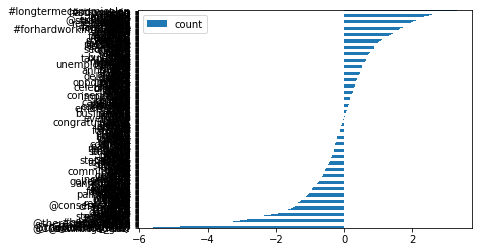

In [173]:
# Visualization of log odds - this needs some work as you cannot really visualize 10,000 words
logodds.drop_duplicates().sort_values(by=['count']).plot(kind='barh')

In [174]:
# TO BE CONTINUED...